## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


##  1. Compute the camera calibration using chessboard images:

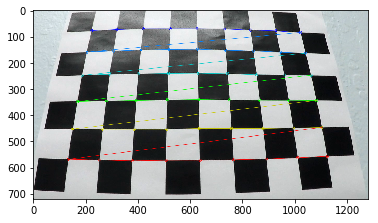

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpImg
import glob 
%matplotlib inline

localPath = 'camera_cal/'
nx = 9 # Number of the inside corners in x.
ny = 6 # number of the inside corners in y.
imgShape = mpImg.imread(localPath + 'calibration1.jpg').shape[1::-1] # Image shape

calibrationImgs = [] # Calibration images array.

objPoints = [] # 3D object points in the real world space.
imgPoints = [] # 3D points in the image plane.

objP = np.zeros((nx*ny, 3), np.float32)
objP[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) # x, y coordinates.

for imgFileName in glob.glob(localPath + 'calibration*.jpg'):
    image = cv2.imread(imgFileName) #read each image.
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert to gray
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None) #find chessboard corners.
    
    if ret == True: # If corners found, add points, image points.
        imgPoints.append(corners)
        objPoints.append(objP)
        
        # Draw and display corners
        image = cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
        calibrationImgs.append(image)
        
# Camera calibration, given object points, image points, and the shape of the grayscale image:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, imgShape, None, None)

# Display Chessboard with corners
plt.imshow(calibrationImgs[2])

Text(0.5,1,'Undistorted Image')

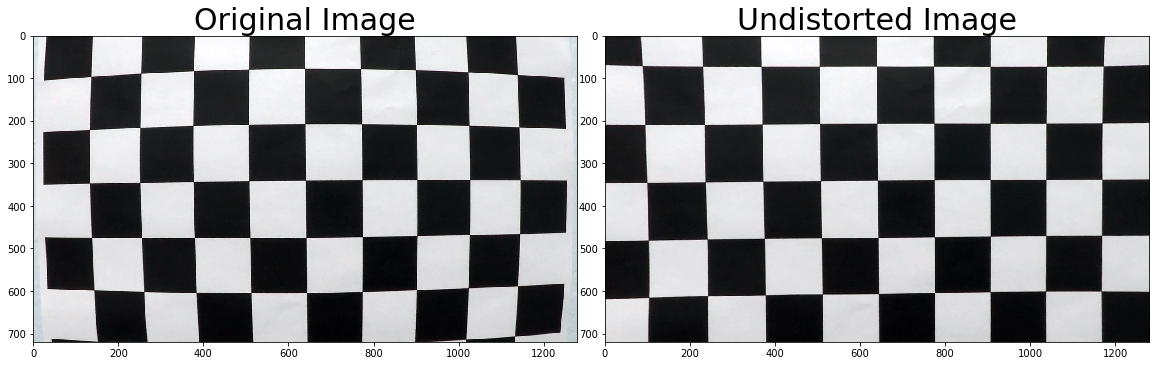

In [2]:
# read one test image from the calibration image set and undistort it.
imgPathList = glob.glob('camera_cal/calibration*.jpg')
testImage = cv2.imread(imgPathList[6]) # grab a distorted, test image.

undistortedImg = cv2.undistort(testImage, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(testImage)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistortedImg)
ax2.set_title('Undistorted Image', fontsize=30)

### 2. Apply a distortion correction to raw images:

In [3]:
inputPath = 'test_images/'
outputPath = 'output_images/undistorted'

# Reading each image from the folder and undistort it.
for imgFileName in glob.glob(inputPath + '*.jpg'):
    image = cv2.imread(imgFileName)
    undistortedImg = cv2.undistort(image, mtx, dist, None, mtx)
    outputFileName = outputPath + imgFileName.split('/')[1] # extacting file name
    cv2.imwrite(outputFileName, undistortedImg) # save undistorted image.
    
print('Done!')

Done!


Text(0.5,1,'Undistorted Image')

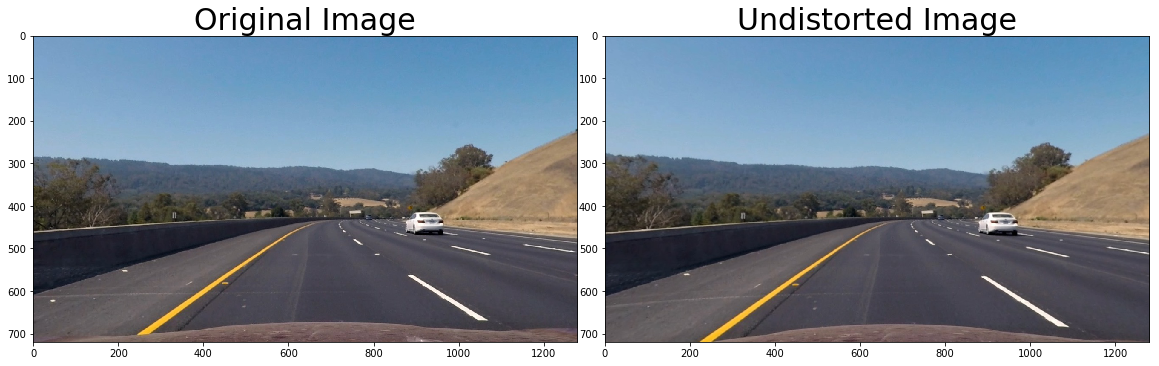

In [4]:
# Display a sample from the undistorted image set.
imgPathList = glob.glob(outputPath + '*.jpg')
testImage = mpImg.imread(imgPathList[5]) # grab a distorted, test image.
undistortedImg = cv2.undistort(testImage, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(testImage)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistortedImg)
ax2.set_title('Undistorted Image', fontsize=30)

### 3. Use color transforms, gradients, etc., to create a thresholded binary image:

In [5]:
inputPath = 'output_images/undistorted/'
outputPath = 'output_images/thresholded/'

# Threshold x gradient
thresh_min = 20
thresh_max = 100

# Threshold S color channel
s_thresh_min = 170
s_thresh_max = 255

# Reading each image from the folder and undistort it.
for imgFileName in glob.glob(inputPath + '*.jpg'):
    image = cv2.imread(imgFileName)
    #convert to gray then apply sobel X.
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # Convert to HLS color space and separate the S channel
    # Note: image is the undistorted image
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    sChannel = hls[:,:,2]
    s_binary = np.zeros_like(sChannel)
    s_binary[(sChannel >= s_thresh_min) & (sChannel <= s_thresh_max)] = 1

    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    combined_binary = combined_binary * 255
    outputFileName = outputPath + imgFileName.split('/')[2] # extacting file name
    cv2.imwrite(outputFileName, combined_binary) # save undistorted image.


print('Done!')

Done!


##### Display a sample from the thresholded image set:

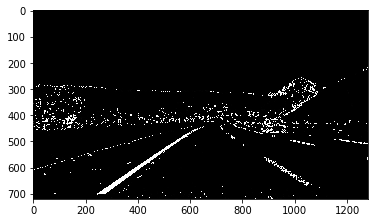

In [6]:
inputPath = 'output_images/thresholded/'

imgPathList = glob.glob(outputPath + '*.jpg')
thresholdSample = mpImg.imread(imgPathList[4]) # grab a distorted, test image.

plt.figure()
plt.imshow(thresholdSample, cmap='gray')


### 4. Apply a perspective transform to rectify binary image ("birds-eye view"):

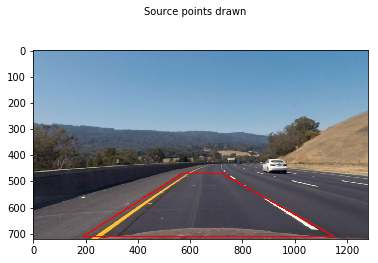

In [7]:
# point to draw the polygon.
pts = np.array([[190,710],[1150,710],[720, 470], [570, 470]], np.int32)
pts = pts.reshape((-1,1,2))
#image with source points drawn on it.
spImg = cv2.polylines(undistortedImg,[pts],True,(255,0,0),4) 
plt.figure()
plt.suptitle('Source points drawn', fontsize=10)
plt.imshow(spImg)

In [8]:
# Applying prespective transfomation. 
inputPath = 'output_images/thresholded/'
outputPath = 'output_images/transformed/'

imgShape = image = cv2.imread(inputPath + 'test1.jpg').shape
imgSize = (imgShape[1], imgShape[0]) # Image shape
# The four points used as src points
bottomLeft = [170,710] 
bottomRight = [1150,710]
topLeft = [570, 470]
topRight = [720, 470]

offset = 210;
# for dst points
distBottomLeft = [170 + offset, 710] 
distBottomRight = [1150 - offset, 710]
distTopLeft = [600 - offset, 0] 
distTopRight = [700 + offset, 0]

srcPoints = np.float32([bottomLeft, bottomRight , topLeft, topRight]) 
dstPoints = np.float32([distBottomLeft, distBottomRight, distTopLeft, distTopRight])
# Compute the perspective transform, M, given source and destination points:
M = cv2.getPerspectiveTransform(srcPoints, dstPoints)

# Reading each image from the folder and undistort it.
for imgFileName in glob.glob(inputPath + '*.jpg'):
    image = cv2.imread(imgFileName)
    warped = cv2.warpPerspective(image, M, imgSize, flags=cv2.INTER_LINEAR)
    outputFileName = outputPath + imgFileName.split('/')[2] # extacting file name
    cv2.imwrite(outputFileName, warped) # save warped image.
   
print('Done!')

Done!


#### Display a sample from the thresholded image set:

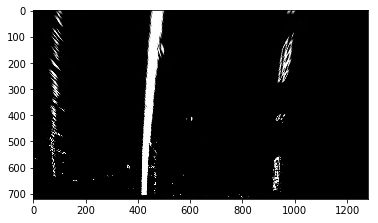

In [9]:
inputPath = 'output_images/transformed/'

imgPathList = glob.glob(outputPath + '*.jpg')
binary_warped = mpImg.imread(imgPathList[4]) # grab a distorted, test image.
plt.figure()
plt.imshow(binary_warped, cmap='gray')


### 5. Detect lane pixels and fit to find the lane boundary.

In [10]:

binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_BGR2GRAY)
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
print(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
print(left_fit)
right_fit = np.polyfit(righty, rightx, 2)

[95026 95027 95028 ..., 15247 15248 15249]
[  1.16355131e-04  -1.43310896e-01   4.81064659e+02]


##### Visualization
At this point, you're done! But here is how you can visualize the result as well:

(720, 0)

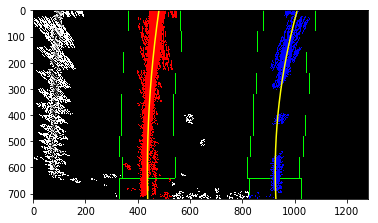

In [11]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [12]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

print("Done!")

Done!


##### visualize the result:

(720, 0)

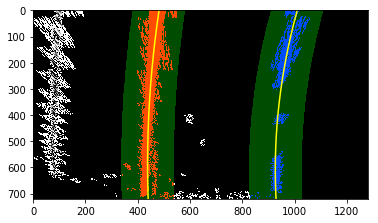

In [13]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

##### Measuring Curvature:

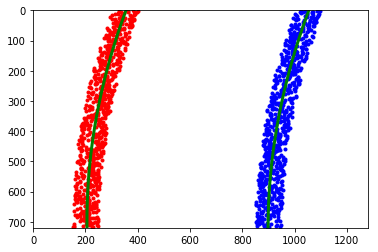

In [14]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [15]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = 500
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

1623.57170717 1676.5130889


In [16]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

533.102853476 m 550.652614811 m
